In [1]:
import cfgrib
import numpy as np
import matplotlib.pyplot as plt
import sys
import torch
from sklearn.preprocessing import MinMaxScaler
sys.path.append("..")

from baselines.data_processor import DataProcessor
from baselines.cnn.cnn import UNet

c:\Users\iwama\Desktop\Maciej\Eng\meteoapp-data\venv\lib\site-packages\gribapi\__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.27.0
  warnings.warn(


In [2]:
# https://github.com/ecmwf/cfgrib/issues/164
grib_data = cfgrib.open_datasets('../data2022-2div.grib')
surface = grib_data[0] 
hybrid = grib_data[1] 

In [3]:
feature_list = ['t2m', 'sp', 'tcc', 'u10', 'v10', 'tp']
n_features = len(feature_list)
t2m = surface.t2m.to_numpy() - 273.15  # -> C
sp = surface.sp.to_numpy() / 100       # -> hPa
tcc = surface.tcc.to_numpy()
u10 = surface.u10.to_numpy()
v10 = surface.v10.to_numpy()
tp = hybrid.tp.to_numpy().reshape((-1,) + hybrid.tp.shape[2:])
data = np.stack((t2m, sp, tcc, u10, v10, tp), axis=-1)

In [4]:
# Normalize the data
scalers = []
for i in range(n_features):
    scaler = MinMaxScaler()
    og_shape = data[..., i].shape
    data[..., i] = scaler.fit_transform(data[..., i].reshape((-1, 1))).reshape(og_shape)
    scalers.append(scaler)

In [5]:
s = 3
fh = 2

processor = DataProcessor(data)
X, y = processor.preprocess(s, fh, use_neighbours=False)
X_train, X_test, y_train, y_test = processor.train_test_split(X, y)

In [6]:
X_train = X_train[175].reshape((1,)+X.shape[1:])
y_train = y_train[175].reshape((1,)+y.shape[1:])
X_test = X_test[17].reshape((1,)+X.shape[1:])
y_test = y_test[17].reshape((1,)+y.shape[1:])
X_train.shape, y_train.shape

((1, 32, 48, 3, 6), (1, 32, 48, 2, 6))

In [7]:
X_train, X_test, y_train, y_test = np.float32(X_train), np.float32(X_test), np.float32(y_train), np.float32(y_test)

In [8]:
train = np.concatenate([X_train, y_train], axis=3)
test = np.concatenate([X_test, y_test], axis=3)

In [9]:
train = train.transpose(0, 3, 4, 1, 2)
test = test.transpose(0, 3, 4, 1, 2)

In [10]:
train.shape, test.shape

((1, 5, 6, 32, 48), (1, 5, 6, 32, 48))

In [11]:
device = (
    "cuda" if torch.cuda.is_available()
    else "cpu"
)
print("Device:", device)

Device: cuda


In [12]:
model = UNet(features=n_features, s=s, fh=fh).to(device)

In [13]:
training_loader = torch.utils.data.DataLoader(train, batch_size=1, shuffle=True)
val_loader = torch.utils.data.DataLoader(test, batch_size=1, shuffle=False)

In [14]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [15]:
num_epochs = 3000
train_loss_list = []
val_loss_list = []

for epoch in range(num_epochs):
    total_loss = 0
    for batch in training_loader:
        inputs = batch[:, :s, ...].reshape(batch.shape[0], s*n_features, batch.shape[3], batch.shape[4]).to(device)
        labels = batch[:, -fh:, ...].reshape(batch.shape[0], fh*n_features, batch.shape[3], batch.shape[4]).to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / train.shape[0]
    train_loss_list.append(avg_loss)

    with torch.no_grad():
        val_loss = 0
        for batch in val_loader:
            inputs = batch[:, :s, ...].reshape(batch.shape[0], s*n_features, batch.shape[3], batch.shape[4]).to(device)
            labels = batch[:, -fh:, ...].reshape(batch.shape[0], fh*n_features, batch.shape[3], batch.shape[4]).to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / test.shape[0]
    if(epoch % 250 == 0):
        print(f"Val Loss: {avg_val_loss:.4f}\n---------")
        print(f"Epoch {epoch+1}/{num_epochs}:\nTrain Loss: {avg_loss:.4f}")
    val_loss_list.append(avg_val_loss)

Val Loss: 0.3565
---------
Epoch 1/3000:
Train Loss: 0.3168
Val Loss: 0.0560
---------
Epoch 251/3000:
Train Loss: 0.0141
Val Loss: 0.0848
---------
Epoch 501/3000:
Train Loss: 0.0045
Val Loss: 0.0802
---------
Epoch 751/3000:
Train Loss: 0.0015
Val Loss: 0.0746
---------
Epoch 1001/3000:
Train Loss: 0.0007
Val Loss: 0.0733
---------
Epoch 1251/3000:
Train Loss: 0.0006
Val Loss: 0.0712
---------
Epoch 1501/3000:
Train Loss: 0.0005
Val Loss: 0.0739
---------
Epoch 1751/3000:
Train Loss: 0.0007
Val Loss: 0.0723
---------
Epoch 2001/3000:
Train Loss: 0.0004
Val Loss: 0.0713
---------
Epoch 2251/3000:
Train Loss: 0.0003
Val Loss: 0.0712
---------
Epoch 2501/3000:
Train Loss: 0.0003
Val Loss: 0.0696
---------
Epoch 2751/3000:
Train Loss: 0.0003


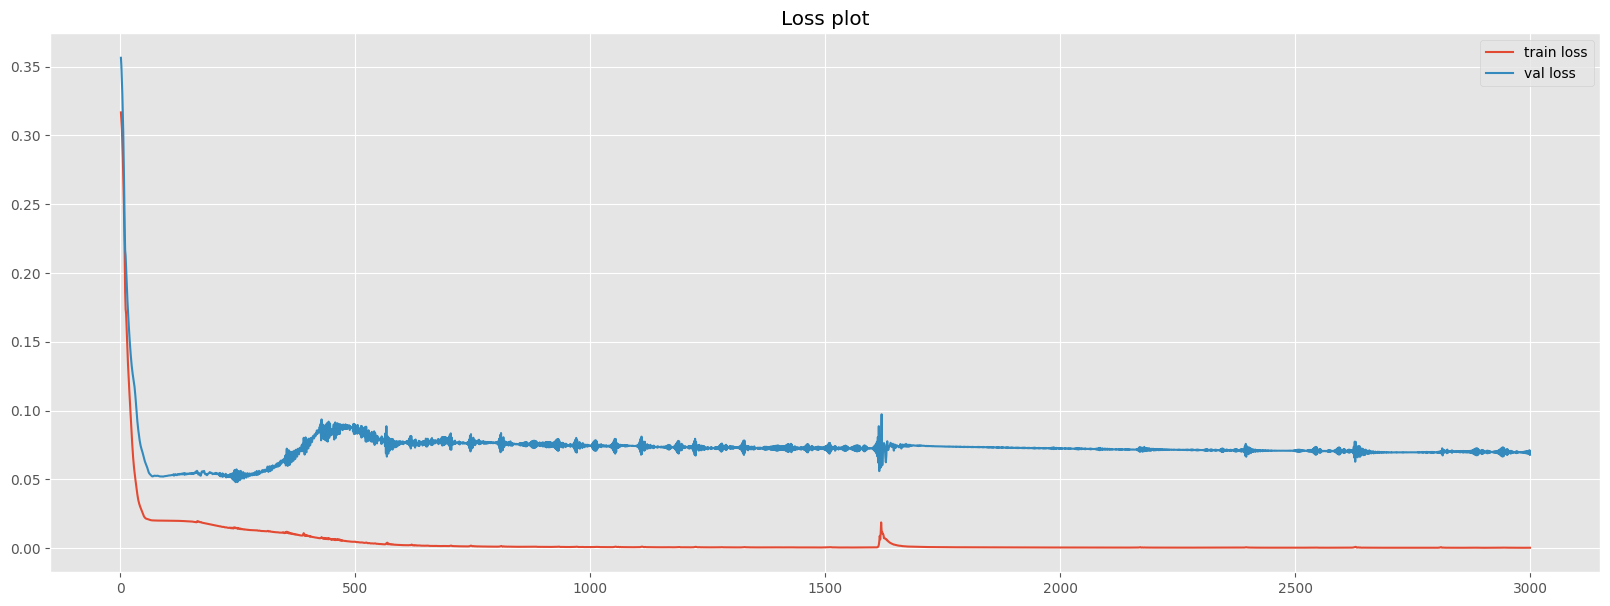

In [16]:
plt.style.use('ggplot')

x = np.arange(1, num_epochs+1)
plt.figure(figsize=(20,7))
plt.plot(x, train_loss_list, label = 'train loss')
plt.plot(x ,val_loss_list, label = 'val loss')
plt.title('Loss plot')
plt.legend()
plt.show()

In [17]:
from sklearn.metrics import mean_squared_error

def plot_predictions(y_hat, y_test, max_samples):
        features = 6
        fh = 2
        s = 3
        feature_list = ['t2m', 'sp', 'tcc', 'u10', 'v10', 'tp']
        for i in range(max_samples):
            y_test_sample, y_hat_sample = y_test[i], y_hat[i]
            fig, ax = plt.subplots(
                features, 3 * fh, figsize=(10 * fh, 3 * features)
            )

            for j in range(features):
                cur_feature = feature_list[j]
                y_test_sample_feature_j = y_test_sample[..., j].reshape(-1, 1)
                y_hat_sample_feature_j = y_hat_sample[..., j].reshape(-1, 1)
                mse = mean_squared_error(
                    y_test_sample_feature_j, y_hat_sample_feature_j
                )
                rmse = np.sqrt(mse)
                std = np.std(y_test_sample_feature_j)
                sqrt_n = np.sqrt(y_test_sample_feature_j.shape[0])
                print(f"{cur_feature} => RMSE:  {round(rmse,5)}; SE: {std / sqrt_n}")

                for k in range(3 * fh):
                    ts = k // 3
                    if k % 3 == 0:
                        title = rf"$X_{{{cur_feature},t+{ts+1}}}$"
                        value = y_test[i, ..., ts, j]
                        cmap = plt.cm.coolwarm
                    elif k % 3 == 1:
                        title = rf"$\hat{{X}}_{{{cur_feature},t+{ts+1}}}$"
                        value = y_hat[i, ..., ts, j]
                        cmap = plt.cm.coolwarm
                    else:
                        title = rf"$|X - \hat{{X}}|_{{{cur_feature},t+{ts+1}}}$"
                        value = np.abs(y_test[i, ..., ts, j] - y_hat[i, ..., ts, j])
                        cmap = "binary"
                    pl = ax[j, k].imshow(value, cmap=cmap)
                    ax[j, k].set_title(title)
                    ax[j, k].axis("off")
                    _ = fig.colorbar(pl, ax=ax[j, k], fraction=0.15)
            plt.show()

t2m => RMSE:  0.8591499924659729; SE: 0.06201856869952298
sp => RMSE:  2.523710012435913; SE: 0.44099043944741834
tcc => RMSE:  0.026660000905394554; SE: 0.005804548784991981
u10 => RMSE:  0.49963998794555664; SE: 0.03607081384063923
v10 => RMSE:  0.5761200189590454; SE: 0.025463104936528317
tp => RMSE:  0.00011999999696854502; SE: 6.199236893585544e-07


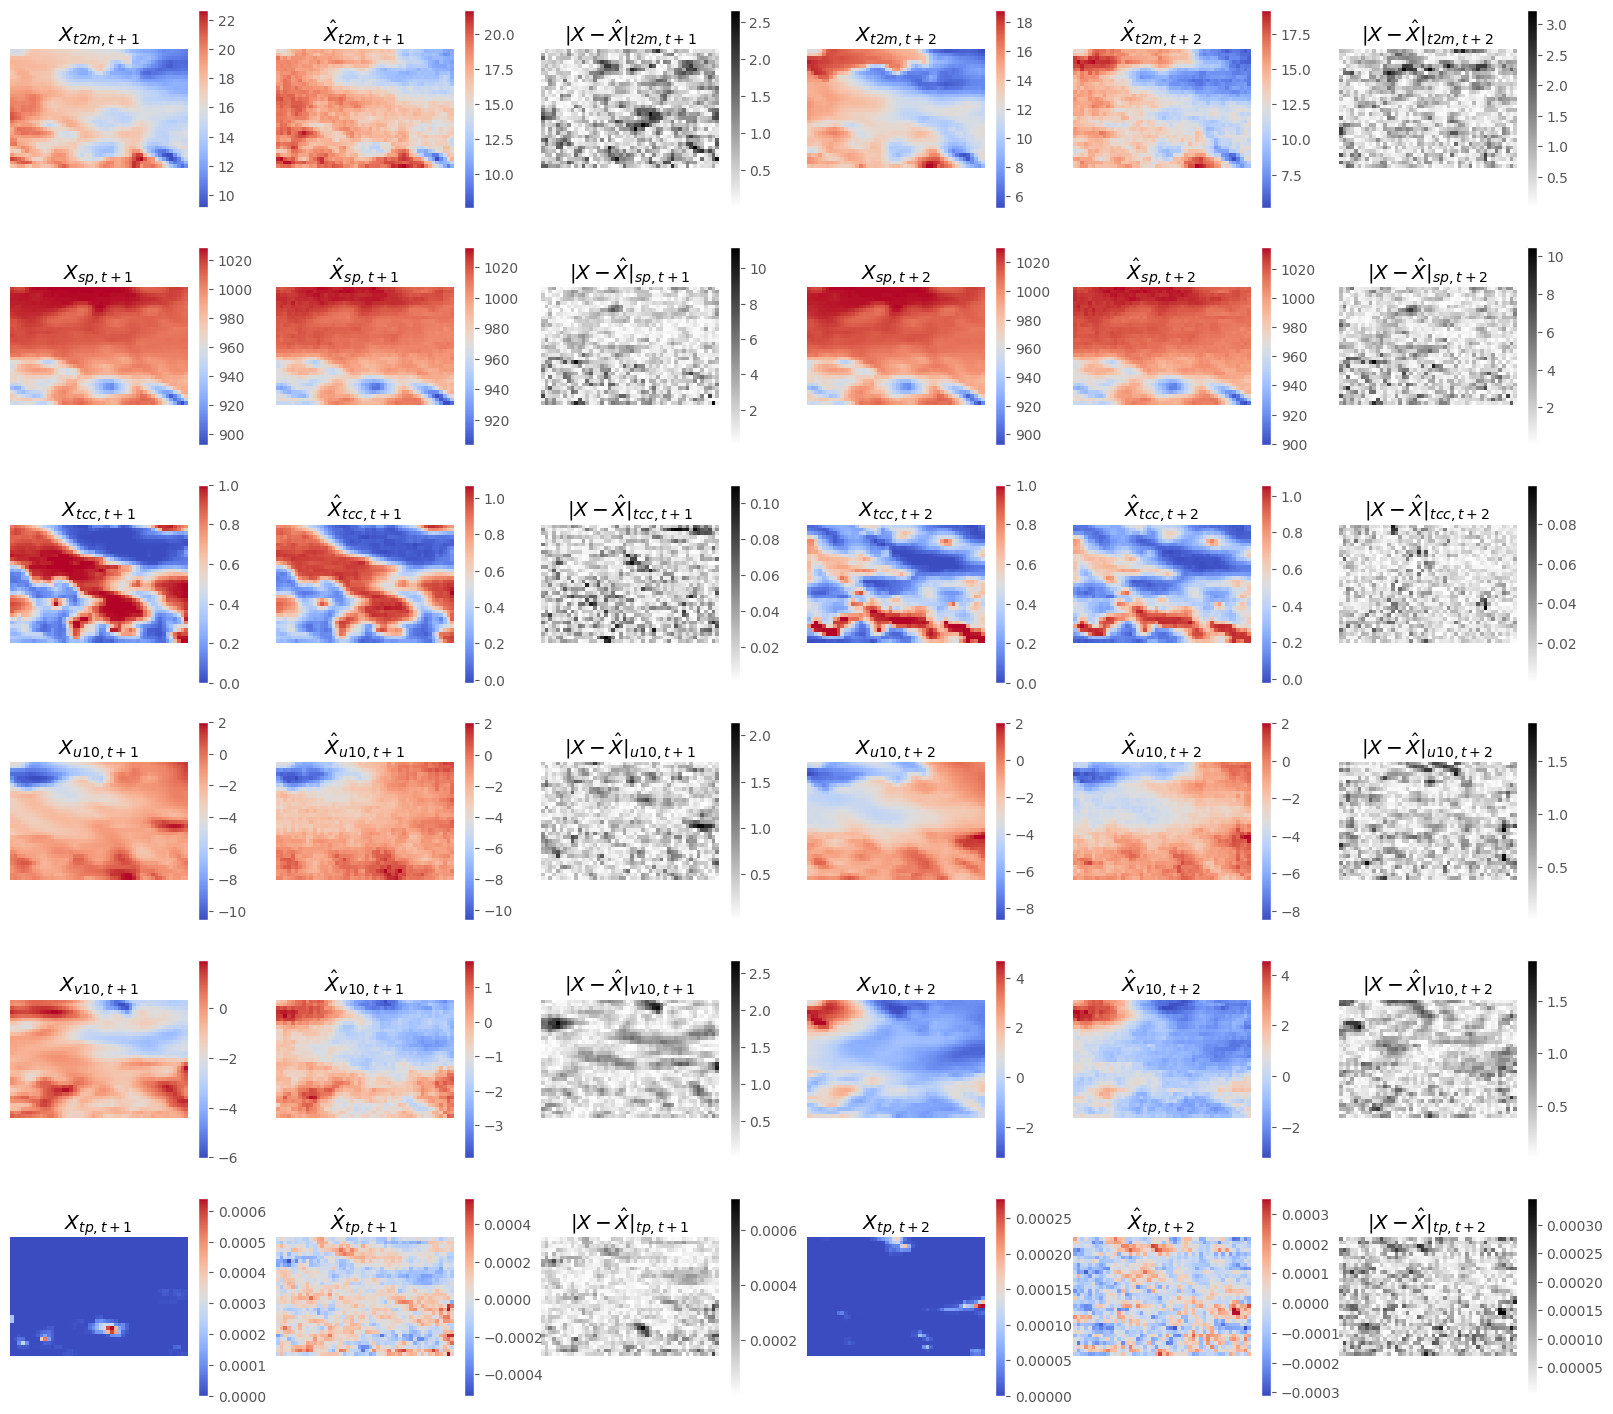

Evaluation metrics for entire test set:
t2m => RMSE: 0.859000027179718;
sp => RMSE: 2.5239999294281006;
tcc => RMSE: 0.027000000700354576;
u10 => RMSE: 0.5;
v10 => RMSE: 0.5759999752044678;
tp => RMSE: 0.0;


In [18]:
y_hat = []
y = []
with torch.no_grad():
    for batch in training_loader:
        inputs = batch[:, :s, ...].reshape(batch.shape[0], s*n_features, batch.shape[3], batch.shape[4]).to(device)
        labels = np.array(batch[:, -fh:, ...].reshape(batch.shape[0], fh*n_features, batch.shape[3], batch.shape[4]).cpu())
        labels = labels.reshape(labels.shape[1:]).transpose(1, 2, 0).reshape(labels.shape[2], labels.shape[3], fh, n_features)
        y.append(labels)
        outputs = np.array(model(inputs).cpu())
        outputs = outputs.reshape(outputs.shape[1:]).transpose(1, 2, 0).reshape(outputs.shape[2], outputs.shape[3], fh, n_features)
        y_hat.append(outputs)

y_hat = np.array(y_hat)
y = np.array(y)
for i in range(n_features):
    og_shape = y_hat[..., i].shape
    y_hat[..., i] = scalers[i].inverse_transform(y_hat[..., i].reshape(-1, 1)).reshape(og_shape)
    og_shape = y[..., i].shape
    y[..., i] = scalers[i].inverse_transform(y[..., i].reshape(-1, 1)).reshape(og_shape)

plot_predictions(y_hat, y, max_samples=1)

print("=======================================")
print("Evaluation metrics for entire test set:")
print("=======================================")

rmse_features = []
for i in range(n_features):
    y_hat_i = y_hat[..., i].reshape(-1, 1)
    y_test_i = y[..., i].reshape(-1, 1)
    err = round(np.sqrt(mean_squared_error(y_hat_i, y_test_i)), 3)
    rmse_features.append(err)
for i in range(n_features):
    print(
        f"{feature_list[i]} => RMSE: {rmse_features[i]};"
    )